# Machine Learning Online Class - Exercise 4 Neural Network Learning

In [384]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, fmin_cg
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt

In [385]:
#Initialization
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

## =========== Part 1: Loading and Visualizing Data ============= 

In [386]:
data = loadmat("ex4data1.mat")
X = data['X']
y = data['y'] #Label for '0' is 10

In [387]:
#randomly select 100 data points to display
rand_indices = random.sample(range(X.shape[0]), 100)
sel = X[rand_indices,:]

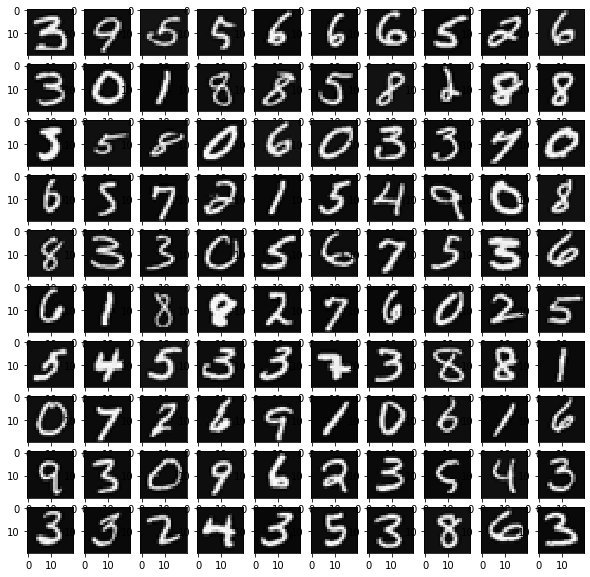

In [388]:
#Display the data as images
fig0, ax = plt.subplots(10,10,figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(sel[10*i+j].reshape(20,20, order='F'), cmap='gray')#order 'F' orders by column, like fortran

In [389]:
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1) #add bias column
X.shape, y.shape

((5000, 401), (5000, 1))

## ================ Part 2: Loading Parameters ================

In [390]:
#We load some pre-initialized parameters
params = loadmat("ex4weights.mat")
Theta1 = params['Theta1']
Theta2 = params['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [391]:
#Unroll parameters
nn_params = np.concatenate((Theta1.reshape(1,Theta1.shape[0]*Theta1.shape[1]),
                           Theta2.reshape(1,Theta2.shape[0]*Theta2.shape[1])), 
                          axis=1)[0]
nn_params.shape

(10285,)

## ================ Part 3: Compute Cost (Feedforward) ================

<img src="nnet.png" width=200/>
<br >
$$J(\Theta)=-\frac{1}{m}\sum_{\alpha=1}^{m}\sum_{i=1}^{n_L} \left[y_{i,\alpha}\log(a^{(L)}_{i})+(1-y_{i,\alpha})\log(1-a^{(L)}_{i}))\right]+\frac{\lambda}{2m}\sum_{k=1}^{L-1}\sum_{s=1}^{n_{k}}\sum_{r=1}^{n_{k+1}}\left(\Theta_{rs}^{(k)}\right)^2,$$
where
$$a_{i}^{(k)}=h(z^{(k)}_{i}),$$
$$a_{i}^{(1)}=x_{i,\alpha},\ 1\leq\alpha\leq m,$$ <br >
$$\Theta^{(k)}=\left(\begin{array}{cccc}
\Theta_{10}^{(k)} & \Theta_{11}^{(k)} & \cdots & \Theta_{1n_k}^{(k)} \\ 
\Theta_{20}^{(k)} & \Theta_{21}^{(k)} & \cdots & \Theta_{2n_k}^{(k)} \\
\vdots & \vdots & \ddots & \vdots \\
\Theta_{n_{k+1}0}^{(k)} & \Theta_{n_{k+1}1}^{(k)} & \cdots & \Theta_{n_{k+1}n_k}^{(k)} \\
\end{array}\right),$$
and
$$z^{(k)}_{i}=\sum_{j=0}^{n_{k-1}}\Theta^{(k-1)}_{ij}a^{(k-1)}_j,\ \ a^{(k-1)}_0=1.$$
If the sigmoid is used as activation function then
$$h(z)=\frac{1}{1+e^{-z}}.$$
NOTE: The vectors $y_{\alpha}$ are one-hot encodings for the different classes in the classification problem.

In [392]:
#Logistic function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

#Regularized neural network cost function (Forward propagation)
def nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels):
    #Retrieve the parameter matrices
    sz1 = hidden_layer_size*(input_layer_size+1)
    sz2 = num_labels*(hidden_layer_size+1)
    #print(sz1,sz2)
    T1 = nn_params[:sz1].reshape((hidden_layer_size,input_layer_size+1))
    T2 = nn_params[sz1:].reshape((num_labels,hidden_layer_size+1))
    #print(T1.shape, T2.shape)
    
    m = X.shape[0] #Number of data samples
    #Obtain layer 2 for all samples
    z2 = np.matmul(X,T1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,np.ones(a2.shape[0]), axis=1)
    #Obtain layer 3 (output) for all samples
    z3 = np.matmul(a2,T2.T)
    a3 = sigmoid(z3)
    #print(a3[0,:])
    
    #One-hot encoding for y in all samples
    ym = np.array([[1 if y[j]==i else 0 for i in [1,2,3,4,5,6,7,8,9,10]] for j in range(m)])
    #print(ym[0,:])
    
    #Copute J without regularization
    J = -(ym*np.log(a3) + (1-ym)*np.log(1-a3)).sum() / m
    
    #Compute the regularization term (delete the bias column)
    R = l * ((T1[:,1:]**2).sum() + (T2[:,1:]**2).sum()) / (2*m) 
    print(J+R)
    return J + R

In [393]:
l = 0
Jval = nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels)
print("Cost at parameters (loaded from ex4weights): {0:f}".format(Jval))
print("(this value should be about 0.287629)")

0.2876291651613189
Cost at parameters (loaded from ex4weights): 0.287629
(this value should be about 0.287629)


## =============== Part 4: Implement Regularization ===============

In [394]:
l = 1
Jval = nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels)
print("Cost at parameters (loaded from ex4weights): {0:f}".format(Jval))
print("(this value should be about 0.383770)")

0.38376985909092365
Cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)


## ================ Part 5: Sigmoid Gradient  ================

In [395]:
#Derivative of the logistic function
def grad_sigmoid(z):
    return sigmoid(z) * (1-sigmoid(z))

In [396]:
g = grad_sigmoid(np.array([-1,-0.5,0,0.5,1]))
print("Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:")
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## ================ Part 6: Initializing Pameters ================

In [397]:
#Parameters are initialized at random small values (between -ep and ep), otherwise all neurons 
# on a layer would be equal
ep = 0.12
ini_Theta1 = ep * (2*np.random.rand(hidden_layer_size,input_layer_size+1)-1)
ini_Theta2 = ep * (2*np.random.rand(num_labels,hidden_layer_size+1)-1)

#unroll parameters
ini_nn_params = np.concatenate((ini_Theta1.reshape(1,ini_Theta1.shape[0]*ini_Theta1.shape[1]),
                                ini_Theta2.reshape(1,ini_Theta2.shape[0]*ini_Theta2.shape[1])),
                               axis=1)[0]
ini_nn_params.shape

(10285,)

## =============== Part 7: Implement Backpropagation ===============

The elements of the gradient can be computed as
$$\frac{\partial J}{\partial\Theta_{ij}^{(k)}}=\left(\begin{array}{ccc}
\frac{\partial J}{\partial a_{1}^{(L)}} & \cdots &\frac{\partial J}{\partial a_{n_L}^{(L)}}\\
\end{array}\right)
\left(\begin{array}{ccc}
\frac{\partial a_{1}^{(L)}}{\partial a_{1}^{(L-1)}} & \cdots & \frac{\partial a_{1}^{(L)}}{\partial a_{n_{L-1}}^{(L-1)}}\\
\vdots & \ddots & \vdots \\
\frac{\partial a_{n_L}^{(L)}}{\partial a_{1}^{(L-1)}} & \cdots & \frac{\partial a_{n_L}^{(L)}}{\partial a_{n_{L-1}}^{(L-1)}}\\
\end{array}\right)\cdots
\left(\begin{array}{ccc}
\frac{\partial a_{1}^{(k+2)}}{\partial a_{1}^{(k+1)}} & \cdots & \frac{\partial a_{1}^{(k+2)}}{\partial a_{n_{k+1}}^{(k+1)}}\\
\vdots & \ddots & \vdots \\
\frac{\partial a_{n_{k+2}}^{(k+2)}}{\partial a_{1}^{(k+1)}} & \cdots & \frac{\partial a_{n_{k+2}}^{(k+2)}}{\partial a_{n_{k+1}}^{(k+1)}}\\
\end{array}\right)
\left(\begin{array}{c}
\frac{\partial a_{1}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}\\
\vdots\\
\frac{\partial a_{n_{k+1}}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}\\
\end{array}\right)+\frac{\lambda}{m}\Theta_{ij}^{(k)}(1-\delta_{j0}),$$
where
$$\frac{\partial J}{\partial a_i^{(L)}}=-\frac{1}{m}\sum_{\alpha=1}^{m}\left(\frac{y_{i,\alpha}}{a_i^{(L)}}-\frac{1-y_{i,\alpha}}{1-a_i^{(L)}}\right)=\frac{1}{m}\sum_{\alpha=1}^{m}\frac{(a_i^{(L)}-y_{i,\alpha})}{a_i^{(L)}(1-a_i^{(L)})},$$
$$\frac{\partial a_{r}^{(k+1)}}{\partial a_{s}^{(k)}}=\frac{\partial h}{\partial z_r^{(k+1)}}\frac{\partial z_r^{(k+1)}}{\partial a_{s}^{(k)}}=h'(z_r^{(k+1)})\Theta_{rs}^{(k)},$$
and
$$\frac{\partial a_{r}^{(k+1)}}{\partial\Theta_{ij}^{(k)}}=\frac{\partial h}{\partial z_r^{(k+1)}}\frac{\partial z_r^{(k+1)}}{\partial\Theta_{ij}^{(k)}}=h'(z_r^{(k+1)})a_j^{(k)}\delta_{ri}.$$
NOTE: $a_j^{(k)}:=a_{j,\alpha}^{(k)}$, where $\alpha$ denotes the sample.

We have then that for $k=L-1$
$$\frac{\partial J}{\partial\Theta_{ij}^{(L-1)}}=\sum_{l=1}^{n_{L}}\frac{\partial J}{\partial a_l^{(L)}}\frac{\partial a_l^{(L)}}{\partial \Theta_{ij}^{(L-1)}}=\frac{1}{m}\sum_{\alpha=1}^{m}\frac{(a_i^{(L)}-y_{i,\alpha})}{a_i^{(L)}(1-a_i^{(L)})}h'(z_i^{(L)})a_j^{(L-1)}=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(L)}h'(z_i^{(L)})a_j^{(L-1)},$$
while for, say, $k=L-3$
\begin{align}
\frac{\partial J}{\partial\Theta_{ij}^{(L-3)}}&=\sum_{s=1}^{n_{L-2}}\sum_{r=1}^{n_{L-1}}\sum_{l=1}^{n_{L}}\frac{\partial J}{\partial a_l^{(L)}}\frac{\partial a_l^{(L)}}{\partial a_r^{(L-1)}}\frac{\partial a_r^{(L-1)}}{\partial a_s^{(L-2)}}\frac{\partial a_s^{(L-2)}}{\partial \Theta_{ij}^{(L-3)}}\\
&=\frac{1}{m}\sum_{\alpha=1}^{m}\underbrace{\sum_{r=1}^{n_{L-1}}\underbrace{\sum_{l=1}^{n_{L}}\underbrace{\frac{(a_l^{(L)}-y_{l,\alpha})}{a_l^{(L)}(1-a_l^{(L)})}}h'(z_l^{(L)})\Theta_{lr}^{(L-1)}}h'(z_r^{(L-1)})\Theta_{ri}^{(L-2)}}h'(z_i^{(L-2)})a_j^{(L-3)}\\
&=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(L-2)}h'(z_i^{(L-2)})a_j^{(L-3)},
\end{align}
that is, in general
$$\frac{\partial J}{\partial\Theta_{ij}^{(k)}}=\frac{1}{m}\sum_{\alpha=1}^{m}\delta_i^{(k+1)}h'(z_i^{(k+1)})a_j^{(k)}+\frac{\lambda}{m}\Theta_{ij}^{(k)}(1-\delta_{j0}),$$
where
$$\delta_r^{(k)}=\sum_{l=1}^{n_{k+1}}\delta_l^{(k+1)}h'(z_l^{(k+1)})\Theta_{lr}^{(k)},$$
and
$$\delta_s^{(L)}=\frac{(a_s^{(L)}-y_{s,\alpha})}{a_s^{(L)}(1-a_s^{(L)})}.$$
In the case where a sigmoid is used as activation function
$$h'(z_r^{(k)})=h(z_r^{(k)})(1-h(z_r^{(k)}))=a_r^{(k)}(1-a_r^{(k)}).$$


In [420]:
#Gradient of the cost function (Not efficient because the a's are computed again)
def grad_nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels):
    #Retrieve the parameter matrices
    sz1 = hidden_layer_size*(input_layer_size+1)
    sz2 = num_labels*(hidden_layer_size+1)
    T1 = nn_params[:sz1].reshape((hidden_layer_size,input_layer_size+1))
    T2 = nn_params[sz1:].reshape((num_labels,hidden_layer_size+1))
    
    #Feedforward to compute a's---------------------------------------------
    m = X.shape[0] #Number of data samples
    #Obtain layer 2 for all samples
    z2 = np.matmul(X,T1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,np.ones(a2.shape[0]), axis=1)
    #Obtain layer 3 (output) for all samples
    z3 = np.matmul(a2,T2.T)
    a3 = sigmoid(z3)
    #print(a2.shape)
    
    #One-hot encoding for y in all samples
    ym = np.array([[1 if y[j]==i else 0 for i in [1,2,3,4,5,6,7,8,9,10]] for j in range(m)])
    
    #Backpropagation to compute gradient------------------------------------
    #Compute delta vector for the last layer (L) for all samples (each row is a sample)
    d3 = (a3 - ym) / (a3*(1-a3))
    d3h = d3 * grad_sigmoid(z3) 
    #print(d3h.shape)
    #Compute gradient with respect to Theta(L-1)
    T2grad = np.zeros((num_labels,hidden_layer_size+1))
    for i in range(m):
        T2grad += np.tensordot(d3h[i],a2[i],axes=0) 
    T2grad[:,1:] += l*T2[:,1:] #add regularization term
    T2grad /= m
    
    #Compute delta vector for layer (L-1) for all samples (each row is a sample)
    d2 = np.zeros((m,hidden_layer_size+1))
    for i in range(m):
        d2[i] = np.matmul(d3h[i],T2)
    d2h = d2[:,1:] * grad_sigmoid(z2)
    #print(d2h.shape)
    #Compute gradient with respect to Theta(L-2)
    T1grad = np.zeros((hidden_layer_size,input_layer_size+1))
    for i in range(m):
        T1grad += np.tensordot(d2h[i],X[i],axes=0)
    T1grad[:,1:] += l*T1[:,1:] #add regularization term
    T1grad /= m
    
    return np.concatenate((T1grad.reshape(1,T1grad.shape[0]*T1grad.shape[1]),
                           T2grad.reshape(1,T2grad.shape[0]*T2grad.shape[1])), 
                          axis=1)[0]


#Compute the gradient using finite differences
def test_grad(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels, mat, i, j):
    sz1 = hidden_layer_size*(input_layer_size+1)
    m = X.shape[0] #Number of data samples
    epsilon = 1.e-4
    aux = nn_params[:]
    
    val = 0
    if mat == 1:
        aux[i*(input_layer_size+1)+j] -= epsilon
        Ji = nnJreg(aux, X, y, l, input_layer_size, hidden_layer_size, num_labels)
        aux[i*(input_layer_size+1)+j] += 2*epsilon
        Jf = nnJreg(aux, X, y, l, input_layer_size, hidden_layer_size, num_labels)
        aux[i*(input_layer_size+1)+j] -= epsilon
        val = (Jf-Ji) / (2*epsilon)
        #print("T1({0},{1}): {2}".format(i,j,val))
    
    if mat == 2:
        aux[sz1+i*(hidden_layer_size+1)+j] -= epsilon
        Ji = nnJreg(aux, X, y, l, input_layer_size, hidden_layer_size, num_labels)
        aux[sz1+i*(hidden_layer_size+1)+j] += 2*epsilon
        Jf = nnJreg(aux, X, y, l, input_layer_size, hidden_layer_size, num_labels)
        aux[sz1+i*(hidden_layer_size+1)+j] -= epsilon
        val = (Jf-Ji) / (2*epsilon)
        #print("T2({0},{1}): {2}".format(i,j,val))
        
    return val

In [421]:
l = 0
Jgrad = grad_nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels)
Jgrad.shape

(10285,)

In [422]:
#Test if the gradient is correct
a = 21#np.random.randint(hidden_layer_size)
b = 147#np.random.randint(input_layer_size+1)
mat = 1
Jgrad_val = test_grad(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels,mat,a,b)
print(Jgrad[a*(input_layer_size+1)+b], Jgrad_val)
print("err({0},{1}): {2}".format(a,b,(Jgrad[a*(input_layer_size+1)+b]-Jgrad_val)/Jgrad_val))

a = np.random.randint(num_labels)
b = np.random.randint(hidden_layer_size+1)
mat = 2
Jgrad_val = test_grad(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels,mat,a,b)
sz1 = hidden_layer_size*(input_layer_size+1)
print(Jgrad[sz1+a*(hidden_layer_size+1)+b], Jgrad_val)
print("err({0},{1}): {2}".format(a,b,(Jgrad[sz1+a*(hidden_layer_size+1)+b]-Jgrad_val)/Jgrad_val))

0.28762914688757985
0.28762918348377153
0.00018298095947355314 0.00018298095844082596
err(21,147): 5.6439051881768944e-09
0.2876290683712116
0.2876292619660837
0.0009679743594427832 0.0009679743603885349
err(3,17): -9.77042122359352e-10


## =============== Part 8: Implement Regularization ===============

In [401]:
l = 1
Jgrad = grad_nnJreg(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels)
Jgrad.shape

(10285,)

In [402]:
#Test if the gradient is correct
a = np.random.randint(hidden_layer_size)
b = np.random.randint(input_layer_size+1)
mat = 1
Jgrad_val = test_grad(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels,mat,a,b)
print(Jgrad[a*(input_layer_size+1)+b], Jgrad_val)
print("err({0},{1}): {2}".format(a,b,(Jgrad[a*(input_layer_size+1)+b]-Jgrad_val)/Jgrad_val))

a = np.random.randint(num_labels)
b = np.random.randint(hidden_layer_size+1)
mat = 2
Jgrad_val = test_grad(nn_params, X, y, l, input_layer_size, hidden_layer_size, num_labels,mat,a,b)
sz1 = hidden_layer_size*(input_layer_size+1)
print(Jgrad[sz1+a*(hidden_layer_size+1)+b], Jgrad_val)
print("err({0},{1}): {2}".format(a,b,(Jgrad[sz1+a*(hidden_layer_size+1)+b]-Jgrad_val)/Jgrad_val))

0.383769859091867
0.38376985909198025
5.661850497203181e-10 5.662137425588298e-10
err(2,3): -5.0674924246930315e-05
0.3837697555656657
0.38376996265935326
0.0010354684340215783 0.0010354684376601142
err(1,16): -3.5139032131100664e-09


## =================== Part 9: Training NN ===================

In [403]:
l = 0.01
fin_nn_params = fmin_cg(nnJreg, ini_nn_params, grad_nnJreg, args=(X,y,l,input_layer_size, hidden_layer_size, num_labels),maxiter=15000)
fin_nn_params[0].shape

6.823460668256257
4.2510041073826335
3.290366283954123
3.2443344531226126
3.236457091748967
3.2083682768271755
3.1572604324952276
2.990645189544437
2.7132217004316197
2.5018002547402283
2.4366305705996627
2.172073021784075
2.035028207202875
1.7610990550215964
1.6510577670126039
1.4876824122637582
1.415601171351264
1.360992115706529
1.3246182577785253
1.2838753053426828
1.2194600382070429
1.1645451694192026
1.0625888307260454
1.0193487083629156
0.9798527341686386
0.9573965353168262
0.8997612015477188
0.8841588733581037
0.8607925091788708
0.8474217492835386
0.8160821256219423
0.8018158159675152
0.7811390648134625
0.7701612499679439
0.7375863762160466
0.7236796148239855
0.700717528295695
0.6624451130352255
0.649033749822048
0.6173670398843883
0.6100596712788002
0.5985108402105379
0.59274640132943
0.5774725202455085
0.5714718844785218
0.5591402826130776
0.5561545439050479
0.5475613467185739
0.54417386236608
0.5385833330799723
0.5241641405156847
0.5199795428391828
0.5105435544509164
0.50824

0.025139711348449688
0.02507220167231612
0.025063039865816587
0.025030691904589127
0.024969561630442387
0.02495989714809799
0.024925091477037344
0.024846996430935298
0.024839477546769514
0.024811825456144243
0.02473990052248133
0.024733212958701015
0.024709449885473037
0.024661944459997108
0.024656688022986983
0.024636404051198657
0.024567094594333427
0.024471646177444985
0.024441815107196736
0.024330088477457094
0.02400248135884203
0.023857158523981972
0.023780779496604718
0.023500526216229403
0.022766664293295744
0.022696969959761483
0.022450713897222738
0.021961469867032637
0.02193381610609851
0.021834639165973398
0.02161907542856535
0.021600969935370914
0.021534136107198225
0.02135336472844463
0.021334574698455025
0.02126591191079491
0.021093353999402757
0.021085208411931976
0.021054080329103227
0.02095248930185814
0.02085405547023385
0.020832344822147433
0.020758083147545927
0.02065203183074021
0.020628688914276418
0.02054767876507398
0.020414567261733838
0.020399032954806173
0.02

0.013175199504356935
0.013168218002575591
0.013167901595708607
0.013166690654162752
0.013162718227956137
0.013158819885102282
0.013158627050117703
0.013157866922862652
0.01315500553416846
0.013146410441239032
0.013141984580090908
0.013141525587242091
0.013139774611020387
0.013134125450487788
0.01312927350655057
0.013128938150305965
0.013127622590016897
0.013122773008443476
0.01310991768144261
0.013109671673090649
0.013108731987367532
0.013105682395241685
0.013102969439068374
0.013102821032532993
0.013102242761663335
0.01310017505043292
0.013095817736731187
0.013095664605268047
0.01309507660212603
0.013093115735421502
0.013090922480250981
0.013090816600707949
0.013090405712766966
0.01308896385948971
0.013086404248709204
0.01308627167554179
0.013085754929575056
0.01308390463998995
0.01307997104134551
0.013079841768207296
0.013079341946908052
0.013077618637973897
0.013075051721825014
0.013074947160719332
0.013074542713774262
0.013073145556369797
0.013071032144364461
0.013070924082780029
0

0.012358815423945782
0.012358604914393636
0.012357790134464879
0.012354966597331141
0.012350558843559335
0.012350357377399108
0.012349592220596155
0.012347180414535707
0.012345435828049055
0.012345265869582667
0.012344609958664517
0.012342368492329793
0.01233928906024787
0.012339096206376321
0.012338354614321544
0.012335865345016435
0.012332959896677022
0.012332769450997625
0.012332039365166466
0.012329625809401109
0.012327136588430977
0.012326940407548429
0.01232618421022994
0.01232361536892401
0.012320278771216785
0.012320115522695756
0.012319492985856408
0.01231748957870594
0.012315812512504864
0.012315645285656505
0.012314996532063104
0.012312723865732103
0.012308790026392256
0.0123086026936515
0.012307889135238215
0.012305606141388653
0.012303773097217708
0.012303610782484254
0.012302984443801571
0.012300845287581241
0.012297923665074071
0.012297750729536133
0.012297089120080313
0.012294924119656306
0.012292861726564668
0.01229271829501202
0.012292165763680479
0.012290294615476182

0.011917952748719526
0.01191655960775512
0.011914451427001375
0.01191433713205321
0.011913895204007418
0.0119123710549063
0.011910088716186646
0.011909988654626055
0.011909603309208438
0.011908300086919066
0.011906670706235838
0.01190658075059954
0.011906234000078095
0.011905056061702817
0.011903528540323269
0.01190345892874184
0.011903189660316189
0.011902259407050092
0.01190085380197171
0.011900773385356216
0.011900462306174801
0.01189938721940372
0.011897751397720056
0.011897670508618195
0.01189735634259315
0.011896249807933239
0.0118942217277493
0.011894123199132597
0.011893743605701742
0.011892457442780368
0.011890827209490702
0.011890743897511163
0.011890419829603425
0.011889270294557682
0.01188701446221925
0.011886912917157533
0.011886522247174638
0.0118852077139649
0.011883641228871738
0.011883572262978714
0.011883304881455269
0.011882371044880675
0.011880803749326926
0.01188072080728811
0.01188040070451419
0.011879306785741905
0.011877807857358263
0.011877723538657743
0.011877

0.011633543118181855
0.011633474949271585
0.011633210070529053
0.011632275188813556
0.011630524157637889
0.011630445386478224
0.01163014276455411
0.011629131398239055
0.01162798685532284
0.011627929298937509
0.011627705925750104
0.011626922036510917
0.011625539479436005
0.011625468920467381
0.011625196117867446
0.011624255664930189
0.011622857167683113
0.011622782055636873
0.011622492363146579
0.011621505488752081
0.011620188867541258
0.011620129147518669
0.011619897895505715
0.011619094860338946
0.01161781766161719
0.011617746937261421
0.011617473693930309
0.011616535221445385
0.011615195088629342
0.011615133170679333
0.011614893899984484
0.011614071102198193
0.011612876222589504
0.011612816050956643
0.011612583422620108
0.01161178169631747
0.011610592186892534
0.011610522717755062
0.01161025288818545
0.011609302268123248
0.011607558001637803
0.01160749065704648
0.011607231679089676
0.011606362037915879
0.011605340030175814
0.011605281732456894
0.011605055782141953
0.01160426769153865

0.011384823987202745
0.011383990879491821
0.011382773809553723
0.01138270770767851
0.011382454353557283
0.011381617675486615
0.011380761715719159
0.011380707876466865
0.011380499519029655
0.011379778161268419
0.011378670603890957
0.011378613760466519
0.011378395717331343
0.0113776728140737
0.011376910683277421
0.011376858105031374
0.011376654088632213
0.011375938720193343
0.01137468692685618
0.011374622017166651
0.011374372191485776
0.011373529850860762
0.011372506857358588
0.011372441271894646
0.011372188153124883
0.01137132335492675
0.011370149035393799
0.01137009194603206
0.011369872688801366
0.011369141243265083
0.011368329635389344
0.011368272879591928
0.011368053706149685
0.011367302524737494
0.011366246073798672
0.011366193778925997
0.011365992599098627
0.01136531590425464
0.011364512348587768
0.01136445957089561
0.011364255895029252
0.011363560176568243
0.011362614891071774
0.011362560760401427
0.011362351132221626
0.011361622885292562
0.011360460625608372
0.011360388433204228


0.011217497643734052
0.01121745908784158
0.011217310433558154
0.011216804862800921
0.011216141301911472
0.011216105501372902
0.011215966962759257
0.011215487367339608
0.011214746067370045
0.011214708301884367
0.011214562962873164
0.01121407312711041
0.011213479509222775
0.01121344813906195
0.011213327190195216
0.011212915892921928
0.011212377813814072
0.011212351073016807
0.011212247992901339
0.011211897777637692
0.011211442751713468
0.01121141489704696
0.011211306898468994
0.011210929596180783
0.011210292541257813
0.011210262082719549
0.01121014437388643
0.011209739532138566
0.011209152448051202
0.011209118133270246
0.01120898528642386
0.011208524483523209
0.011207800499414203
0.01120776638906717
0.011207634597490676
0.011207181785092998
0.01120653017595924
0.01120649317048478
0.011206350352457685
0.0112058622568814
0.011205191946696832
0.011205159669244489
0.011205034976523469
0.011204606861349536
0.011203995823434813
0.011203963363695972
0.011203838347938765
0.011203415469793834
0.0

0.011107798655009807
0.01110748339192142
0.011107010125712007
0.011106986079918266
0.011106893231919142
0.011106575180511731
0.011106130260582771
0.011106106850226833
0.01110601604173228
0.011105698107893854
0.011105149449572495
0.0111051232374699
0.01110502191789751
0.011104673120526706
0.011104164106247351
0.011104136875423554
0.011104031336691354
0.011103663338152766
0.011103055599234583
0.011103027537139184
0.011102919085342165
0.01110254599857338
0.01110200322211591
0.011101975052597992
0.01110186641026598
0.011101496372266671
0.011101004283875905
0.011100982386382479
0.011100897784109004
0.01110060718056983
0.011100191086629836
0.011100168100509065
0.011100079064014487
0.011099769451984185
0.01109927171806163
0.0110992465580581
0.011099148861495364
0.01109880515065344
0.01109818249361904
0.011098153852417345
0.011098043498268323
0.011097669412836096
0.011097192550120028
0.011097168019937402
0.011097072677666379
0.011096735765168708
0.011096099752748745
0.01109607126486741
0.01109

()

In [404]:
fin_nn_params
#print("J: {0}".format(fin_nn_params[1]))
#print(fin_nn_params[0])
#print(fin_nn_params[2])

array([-1.77116544e+00,  4.42342575e-03, -3.93308855e-04, ...,
       -5.74594815e+00, -5.86472274e+00,  5.10282340e+00])

In [405]:
#Out = open("fin_nn_params.dat", "w")
#for q in fin_nn_params:
#    Out.write("{0} ".format(q))
#Out.close()

In [406]:
#f_nn_params = np.array([0 for i in range(ini_nn_params.shape[0])])
#In = open("fin_nn_params.dat", "r")
#dat = In.readline().split()
#for i in range(f_nn_params.shape[0]):
#    f_nn_params[i] = float(dat[i])
#In.close()
#f_nn_params.shape

In [407]:
sz1 = hidden_layer_size*(input_layer_size+1)
Theta1 = fin_nn_params[:sz1].reshape((hidden_layer_size,input_layer_size+1))
Theta2 = fin_nn_params[sz1:].reshape((num_labels,hidden_layer_size+1))
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

## ================= Part 10: Visualize Weights =================

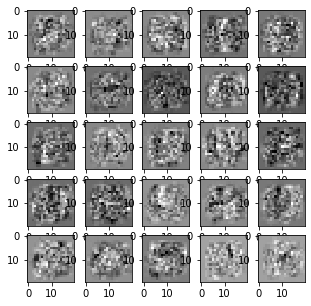

In [408]:
#Display the data as images
fig1, ax = plt.subplots(5,5,figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(Theta1[5*i+j,1:].reshape(20,20), cmap='gray')

## ================= Part 11: Implement Predict =================

In [409]:
#Function to predict all the samples in the training set with the trained model
def predict(T1, T2, X, id):
    z2 = np.matmul(X,T1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,np.ones(a2.shape[0]), axis=1)
    #Obtain layer 3 (output) for all samples
    z3 = np.matmul(a2,T2.T)
    a3 = sigmoid(z3)
    print(a3[id])
    
    
    pp = np.array([[np.where(row == np.max(row))[0][0]] for row in a3])
    p = np.array([[i if i>0 else 10] for i in pp])
    return p

In [410]:
id = 1502
pred = predict(Theta1, Theta2, X, 0)
pred.shape

[3.70657502e-13 4.33949321e-06 4.80503793e-11 4.36798374e-12
 1.32259628e-06 7.92080189e-10 1.08575464e-05 1.63311056e-10
 1.35707371e-07 9.99997996e-01]


(5000, 1)

[3]


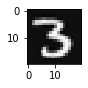

In [411]:
print(y[id])
fig1, ax = plt.subplots(1,1,figsize=(1, 1))
ax.imshow(X[id,1:].reshape(20,20, order='F'), cmap='gray')#order 'F' orders by column, like fortran

In [412]:
print("Training set accuracy: {0:.3f}".format(np.mean(pred==y)))

Training set accuracy: 0.000


_____________________________________________________________________________
_____________________________________________

In [413]:
#Reshape and concatenate several matrices into a single long vector:
import numpy as np

T1 = np.ones((10,11))
T2 = 2*np.ones((10,11))
T3 = 3*np.ones((1,11))

Tvec = np.concatenate((T1.reshape(1,T1.shape[0]*T1.shape[1]),
                       T2.reshape(1,T2.shape[0]*T2.shape[1]),
                       T3.reshape(1,T3.shape[0]*T3.shape[1])),
                      axis=1)
Tvec

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 

In [414]:
#Get matrices back
ind1 = T1.shape[0]*T1.shape[1]
ind2 = T1.shape[0]*T1.shape[1]+T2.shape[0]*T2.shape[1]
Tvec[0][ind1:ind2].reshape((T2.shape[0],T2.shape[1]))

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [415]:
#Create a random matrix
e = 0.2
R = e * (2*np.random.rand(3,4)-1)
R

array([[ 0.04633307,  0.03278718,  0.05177732, -0.07570567],
       [ 0.17314503, -0.02996253, -0.00672843,  0.09219787],
       [ 0.08610613,  0.15649827, -0.18128383, -0.10732604]])